In [1]:
# Load text files
def loadFile(name):
    with open(name, 'r', encoding='iso-8859-2') as f:
        return [x.rstrip('\n') for x in f.readlines()]

textcz = loadFile('TEXTCZ1.txt')
texten = loadFile('TEXTEN1.txt')

In [2]:
# Generate n-grams and compute frequencies
import collections

def generateNgrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ngrams

def frequency(ngram):
    return collections.Counter(ngram)

def distribution(ngram):
    freq = frequency(ngram)
    total = float(sum(freq.values()))
    return {k:v/total for (k,v) in freq.items()}

In [3]:
# Compute entropy
import math
def condEntropy(tokens):
    gram1, gram2 = list(generateNgrams(tokens, 1)), list(generateNgrams(tokens, 2))
    dist1, dist2 = distribution(gram1), distribution(gram2)
    total = 0.0
    for (i,j) in set(gram2):
        if dist1[(i,)] != 0 and dist2[(i,j)] != 0:
            p = dist2[(i,j)]/dist1[(i,)]
            total -= dist2[(i,j)] * math.log(p, 2)
    return total

def simpleEntropy(tokens):
    gram1 = list(generateNgrams(tokens, 1))
    dist1 = distribution(gram1)
    total = 0.0
    for i in set(gram1):
        if dist1[i] != 0:
            total -= dist1[i]*math.log(dist1[i], 2)
    return total

In [4]:
# Define the mess functions
import random

def messChar(tokens, prob=0.0):
    alphabet = list(set(''.join(tokens)))
    tokens2 = list(tokens)
    for i in range(len(tokens2)):
        for j in range(len(tokens2[i])):
            if random.random() < prob:
                # the character can be replaced by itself
                new = list(tokens2[i])
                new[j] = random.choice(alphabet)
                tokens2[i] = ''.join(new)
    return tokens2

def messWord(tokens, prob=0.0):
    alphabet = list(set(tokens))
    tokens2 = list(tokens)
    for i in range(len(tokens2)):
        if random.random() < prob:
            # the word can be replaced by itself
            tokens2[i] = random.choice(alphabet)
    return tokens2

In [5]:
# Run the first experiment
from IPython.display import display
import pandas as pd

PROBS = [0, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, .2, .3, .4, .5]
def experiment1(tokens, messFun, repeat=1):
    out = []
    for probI in range(len(PROBS)):
        random.seed(0)
        entropies = []
        for i in range(repeat):
            tokensModified = messFun(tokens, PROBS[probI])
            entropies.append(condEntropy(tokensModified))
        out.append((probI, PROBS[probI], sum(entropies)/len(entropies), min(entropies), max(entropies)))
    print('-')
    return pd.DataFrame(data=out, columns=['index', 'prob', 'avg', 'min', 'max'])

expCzChar = experiment1(textcz, messChar)
expCzWord = experiment1(textcz, messWord)
expEnChar = experiment1(texten, messChar)
expEnWord = experiment1(texten, messWord)

-
-
-
-


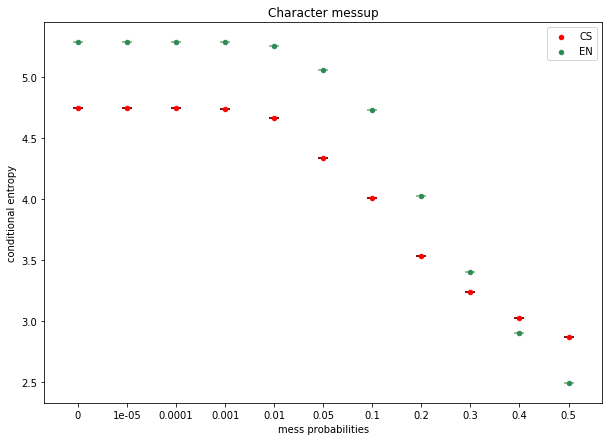

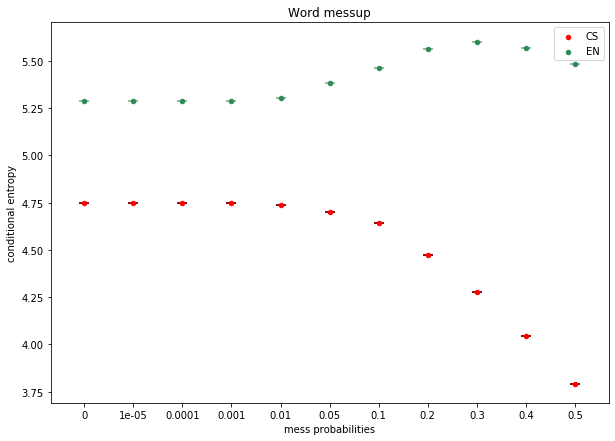

In [10]:
# Plot the relevant graphs for experiment 1
import matplotlib.pyplot as plt

def plotEx1(exps, cols, labels, title=''):
    ax = plt.gca()
    plt.xticks(range(len(PROBS)), PROBS)
    for (exp,col,lab) in zip(exps, cols, labels):
        exp.plot(kind='scatter', color='Dark'+col, marker="_", s=100, y='min', x='index', ax=ax)
        exp.plot(kind='scatter', color='Dark'+col, marker="_", s=100, y='max', x='index', ax=ax)
        exp.plot(kind='scatter', color=col, y='avg', x='index', ax=ax, label=lab, figsize=(10,7))
    plt.xlabel('mess probabilities'), plt.ylabel('conditional entropy')
    plt.title(title), plt.show()

plotEx1([expCzChar, expEnChar], ['Red', 'Seagreen'], ['CS', 'EN'], "Character messup")
plotEx1([expCzWord, expEnWord], ['Red', 'Seagreen'], ['CS', 'EN'], "Word messup")

The tables Character messup and Word messup describe the relationship between the messup probability for characters and words respectively and conditional entropy of the resulting text. All of the mentioned phenomena are explained in detail after the next table and graphs are introduced.

### Character messup
The conditional entropy for character messup is decreasing for both Czech and English. The initial conditional entropy for English is higher than the one for Czech. The conditional entropy is also decreasing faster for the former language.

### Word messup
The conditional entropy for word messup is first increasing for English, but then it starts to decrease around `p = 0.5`. The conditional entropy for Czech is lower than for English and is decreasing already from the beginning.

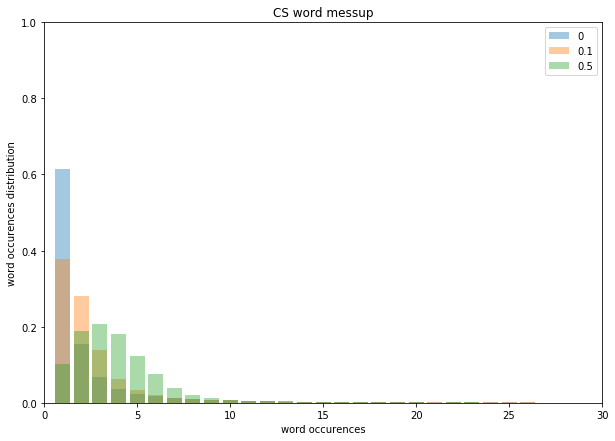

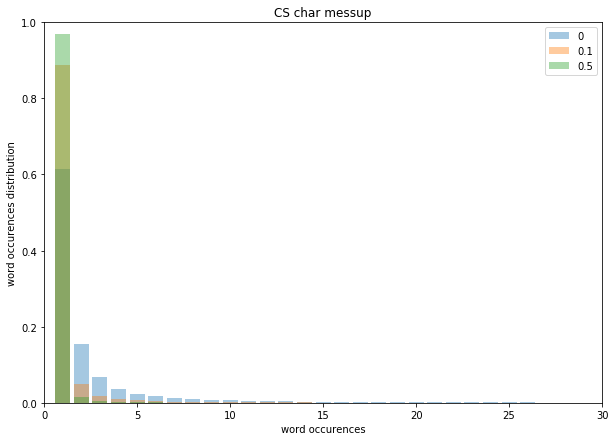

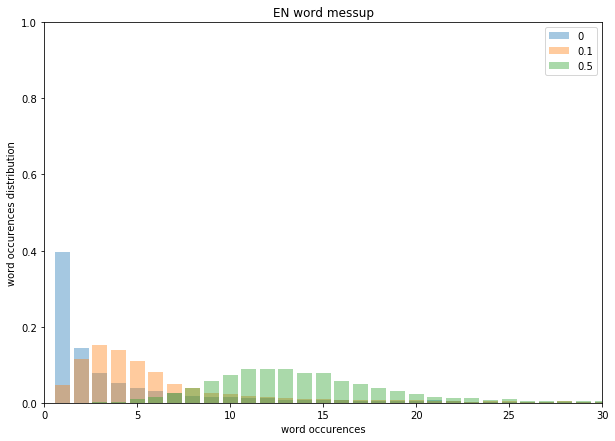

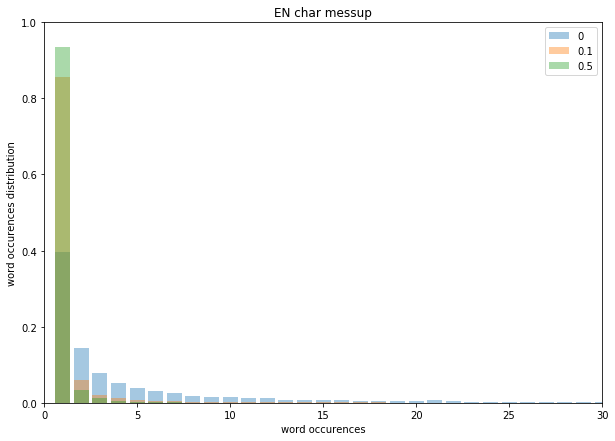

In [7]:
# Plot bucket distribution
def plotWordOccurence(tokens, messFunc, title):
    f, ax = plt.subplots(figsize=(10,7)) 
    for prob in [0, 0.1, 0.5]:
        D = distribution(frequency(messFunc(tokens, prob)).values())
        Ds = collections.OrderedDict(sorted(D.items()))
        plt.bar(list(Ds.keys()), list(Ds.values()), alpha=0.4, label=prob)
        plt.legend()
    plt.xlabel("word occurences"), plt.ylabel("word occurences distribution")
    plt.ylim(0, 1), plt.xlim(0, 30)
    plt.title(title), plt.show()

plotWordOccurence(textcz, messWord, 'CS word messup')
plotWordOccurence(textcz, messChar, 'CS char messup')
plotWordOccurence(texten, messWord, 'EN word messup')
plotWordOccurence(texten, messChar, 'EN char messup')

In [8]:
# Tabulate language statistics
from tabulate import tabulate
def calcStat(lang, tokens):
    alphabet = set(''.join(tokens))
    wordLengths = [len(x) for x in tokens]
    bigrams = generateNgrams(tokens, 2)
    return [lang, len(alphabet), sum(wordLengths)/float(len(wordLengths)), len(set(tokens)), len(set(bigrams))]

statCS = calcStat('CS', textcz)
statEN = calcStat('EN', texten)

stats = pd.DataFrame(data=[statCS, statEN], columns=['language', 'unique characters', 'avg word length', 'unique words', 'unique bigrams'])
stats.round(2)

,language,unique characters,avg word length,unique words,unique bigrams
0,CS,117,4.63,42826,147136
1,EN,74,4.40,9607,73246


### Word occurences distribution tables
The previous four graphs (CS/EN word/char messup) display multiple histograms with respect to the messup probabilities. The histograms are distributions of word occurences. The __x__ axis determines the number of occurences and the __y__ axis the distribution of such words. There are always three semitransparent histograms in one graph for messup probabilities __0, 0.1__ and __0.5__.

### Initial values
The initial conditional entropy of English is higher than for Czech. We attribute this to the lower number of words that appear only once (singletons) in English, as is apparent from the the EN char/word messup histograms (leftmost bars). Singletons do not contribute to the entropy, becasue `log(p(x|y)/p(y)) = log(p(y)/p(y)) = 0`. 

### Character messup
The conditional entropy of English with character messup is decreasing faster, because more words get turned to singleton words, whilst in Czech many of the words were singletons already from the beginning.

### Word messup
The progression of conditional entropies for word messups is more variable. There are mainly two factors after creating a new bigram, that affect the entropies:

1. Increasing entropy: new random bigram already exists in the text
2. Decreasing entropy: new random bigram is unique

For Czech, the first factor is insignificant from the beginnig, as there are many unique bigrams and much more unique words than in English (see the above table). For Czech the second factor is higher because of the same reasons.

Since English has lower number of unique words, the chance of creating a unique bigram is initially low. As the messup probability increases, the words are becomming to be distributed uniformly. This results in histograms with normal-like curves. With more uniform distribution, more random words start to appear next to each other and due to the initially lower number of unique bigrams, the second factor starts getting more significant.

In [9]:
textr1 = ['a', 'b', 'a', 'b', 'c', 'c', 'c', 'c', 'a', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'x']
textr1 = ['a', 'a', 'x']
textr2 = [x.upper() for x in textr1]
print(condEntropy(textr1))
print(condEntropy(textr2))
print(condEntropy(textr1+textr2))
# zvysis se, ale v nekonecnu budou stejny
# p(x) -> p(x)/2
# p(x,y) -> p(x,x) * n/(2n+1)
# H' = - sum 2n/(2n+1) log(p(x|y) * 2n/(2n+1)) 

0.4150374992788438
0.4150374992788438
0.5369655941662059
